# 6. Implementing a simple Seq2Seq model

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (05/03/2024)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)
- Torch (tested on v2.0.1+cu118)

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Generating a synthetic dataset

The code below will generate a synthetic dataset. Just like before it boils down to predicting the next values of a sinsusoid curve of some sort.

This time however, at each time $ t $, the model will get to see the last five values as inputs $ (x_{t-4}, x_{t-3}, x_{t-2}, x_{t-1}, x_{t}) $ and will attempt to predict the next five values $ (x_{t+1}, x_{t+2}, x_{t+3}, x_{t+4}, x_{t+5}) $.

The dataset and dataloaders are generated below.

In [3]:
# Our function to generate synthetic data
def generate_data(seq_length, num_samples):
    x = np.linspace(0, 2 * np.pi, seq_length + 1)
    sine_wave_sequences = np.sin(x)[:-1]
    return np.array([sine_wave_sequences for _ in range(num_samples)])

In [4]:
# Input sequence length
seq_length = 10
# Number of samples in the dataset
num_samples = 1000
# Generate dataset
data = generate_data(seq_length, num_samples)

In [5]:
class SineDataset(Dataset):
    def __init__(self, data, future_steps):
        self.data = data
        self.future_steps = future_steps

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx, :self.future_steps]
        y = self.data[idx, self.future_steps:]
        # Add an extra dimension to match (sequence_length, input_size)
        return torch.from_numpy(x).unsqueeze(-1).float(), torch.from_numpy(y).unsqueeze(-1).float()

In [6]:
# Define future steps to predict
future_steps = seq_length//2 # This is 5

# Create dataset and dataloader
dataset = SineDataset(data, future_steps)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

In [7]:
# Draw a single sample to see what it looks like
sample = next(iter(dataset))
input, output = sample
print(input)
print(output)

tensor([[0.0000],
        [0.5878],
        [0.9511],
        [0.9511],
        [0.5878]])
tensor([[ 1.2246e-16],
        [-5.8779e-01],
        [-9.5106e-01],
        [-9.5106e-01],
        [-5.8779e-01]])


### Our encoder model

The EncoderRNN below processes input sequences through an LSTM. It is designed to capture the temporal dependencies in the data.
Only the final hidden states are returned, encapsulating the learned representation of the entire sequence. This encoder can be used in sequence-to-sequence models, where its hidden state initializes the decoder to generate outputs based on the input sequence.

It uses several layers of LSTM and possibly dropout.

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, \
                 num_layers = 1, dropout = 0.0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, \
                           num_layers = num_layers, 
                           dropout = dropout if num_layers > 1 else 0.0, 
                           batch_first = True)

    def forward(self, input_seq):
        # For this encoder, we ignore the outputs 
        # if we only need the final hidden state(s)
        outputs, hidden = self.rnn(input_seq)
        return hidden

### Our decoder model

The DecoderRNN class is a PyTorch module designed to act as the decoder in a sequence-to-sequence architecture. It processes input sequences using an LSTM and then maps the LSTM outputs to the desired output space with a linear layer. It returns both the predicted output and the updated hidden state, making it suitable for sequential decoding in sequence-to-sequence tasks.

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, \
                 num_layers = 1, dropout = 0.0):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, \
                           num_layers = num_layers, 
                           dropout = dropout if num_layers > 1 else 0.0, 
                           batch_first = True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden):
        # Get the raw output from the RNN 
        # along with updated hidden state(s)
        output, hidden = self.rnn(input_seq, hidden)
        output = self.linear(output)
        return output, hidden

### Our Seq2Seq model

Assembling our encoder and decoder classes from earlier, the Seq2Seq class implements a sequence-to-sequence model using an encoder-decoder architecture. The encoder processes the input sequence to produce a final hidden state, which is then used as the starting point for the memory vector of the decoder. The decoder is then responsible for generating the output sequence.

In [10]:
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1, dropout = 0.0):
        super(Seq2Seq, self).__init__()
        self.num_layers = num_layers
        self.encoder = EncoderRNN(input_size, hidden_size, num_layers, dropout)
        self.decoder = DecoderRNN(input_size, hidden_size, output_size, num_layers, dropout)

    def forward(self, input_seq, target_seq_length):
        # Encoder part: obtain the hidden state from the encoder.
        # Returns a tuple (hidden_state, cell_state)
        encoder_hidden = self.encoder(input_seq)
        
        # Prepare a non-autoregressive decoder input.
        # Use the last time step from input_seq as the initial decoder input.
        # For instance, use a fixed start token or learnable embeddings for each time step.
        batch_size = input_seq.size(0)
        # Here we simply repeat the last time step for all target positions.
        decoder_input = input_seq[:, -1].unsqueeze(1).repeat(1, target_seq_length, 1)
        
        # Then, directly process the entire sequence in the decoder.
        decoder_output, _ = self.decoder(decoder_input, encoder_hidden)
        
        return decoder_output

### A simple trainer function

Our trainer function will be kept simple and will be similar to many other things we have seen this term.

In [11]:
def train_seq2seq(model, dataloader, num_epochs, learning_rate):
    model.train()  # Set the model to training mode
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0
        for input_seq, target_seq in dataloader:
            optimizer.zero_grad()
            output_seq = model(input_seq, future_steps)
            loss = criterion(output_seq, target_seq)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}')

And it trains!

In [12]:
# Hyperparameters
input_size = 1 
hidden_size = 100
output_size = 1
learning_rate = 0.001
num_epochs = 100
num_layers = 3
dropout_rate = 0.1

# Initialize Seq2Seq Model
seq2seq_model = Seq2Seq(input_size, hidden_size, \
                        output_size, num_layers, dropout_rate)

# Train the model
train_seq2seq(seq2seq_model, dataloader, num_epochs, learning_rate)

Epoch 1/100, Loss: 0.23013523453846574
Epoch 2/100, Loss: 0.05715356441214681
Epoch 3/100, Loss: 0.023075181350577623
Epoch 4/100, Loss: 0.00453930161165772
Epoch 5/100, Loss: 0.0011029887355107348
Epoch 6/100, Loss: 0.00035353282328287605
Epoch 7/100, Loss: 0.000263183221250074
Epoch 8/100, Loss: 0.0002178283284592908
Epoch 9/100, Loss: 0.00018316176283406094
Epoch 10/100, Loss: 0.00015721492127340753
Epoch 11/100, Loss: 0.00014322761171570164
Epoch 12/100, Loss: 0.00012563662721731816
Epoch 13/100, Loss: 0.00011474578650449985
Epoch 14/100, Loss: 0.00010283448000336648
Epoch 15/100, Loss: 9.654932955527329e-05
Epoch 16/100, Loss: 9.278620473196497e-05
Epoch 17/100, Loss: 8.875227604221436e-05
Epoch 18/100, Loss: 8.629714420749224e-05
Epoch 19/100, Loss: 7.969939224494738e-05
Epoch 20/100, Loss: 8.667227075420669e-05
Epoch 21/100, Loss: 7.952877922434709e-05
Epoch 22/100, Loss: 7.494891997339437e-05
Epoch 23/100, Loss: 7.321187399611517e-05
Epoch 24/100, Loss: 7.398235538857989e-05
Ep

### A bit of evaluation to confirm

The code below will simply extract one sample from the dataset and confirm that our model predicts correctly.

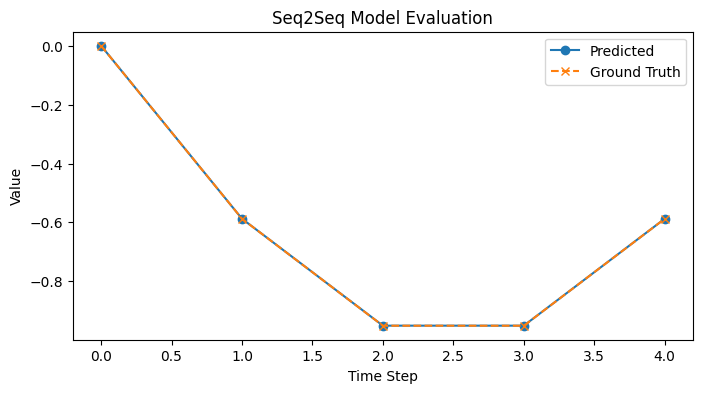

In [13]:
# Switch the model to evaluation mode
seq2seq_model.eval()

# Choose a sample from the dataset (in practice we should probably use a separate test set)
sample_input, sample_target = dataset[0]
# Add batch dimension first
sample_input = sample_input.unsqueeze(0)

with torch.no_grad():
    # Get predictions for the defined future steps
    predicted_output = seq2seq_model(sample_input, future_steps)

# Remove extra dimensions and convert tensors to numpy arrays for plotting
predicted_output = predicted_output.squeeze().cpu().numpy()
sample_target = sample_target.squeeze().cpu().numpy()

# Plot the predicted vs. true values
plt.figure(figsize = (8, 4))
plt.plot(predicted_output, label = 'Predicted', marker = 'o')
plt.plot(sample_target, label = 'Ground Truth', marker = 'x', linestyle = '--')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Seq2Seq Model Evaluation')
plt.legend()
plt.show()